In [1]:
import os
import numpy as np
from scipy.stats import ttest_ind
import pandas as pd


# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 3, 'ytick.major.width': 1, 'ytick.major.size': 3})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
peak_cov_dir = "/data5/deepro/starrseq/papers/reproducibility/5_peak_qc/data/peak_cov"
control_cov_dir = "/data5/deepro/starrseq/papers/reproducibility/5_peak_qc/data/neg_control_cov"
libnames = ["CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]

In [4]:
def read_cov_files(cov_dir, lib_short):
    in_file = os.path.join(cov_dir, lib_short, "input.csv")
    out_file = os.path.join(cov_dir, lib_short, "output.csv")
    in_df = pd.read_csv(in_file, index_col=[0,1,2])
    out_df = pd.read_csv(out_file, index_col=[0,1,2])
    return in_df, out_df


def get_rpkm_norm_df(df):
    reg_kilo_lens = (df.index.get_level_values(2) - df.index.get_level_values(1))*1000
    return df.div(reg_kilo_lens, axis=0)


def get_lib_fc_df(peak_cov_dir, control_cov_dir, lib_name):
    # read rpm normalized cov files
    in_peak_cov_df, lib_peak_cov_df = read_cov_files(peak_cov_dir, lib_name)
    in_neg_control_cov_df, lib_neg_control_cov_df = read_cov_files(control_cov_dir, lib_name)
    # create fold change dfs
    peak_fc_df = lib_peak_cov_df.div(in_peak_cov_df).mean(axis=1).to_frame(name="fold_change")
    peak_fc_df = np.log2(peak_fc_df)
    peak_fc_df["type"] = "peaks"
    neg_control_fc_df = lib_neg_control_cov_df.div(in_neg_control_cov_df).replace([np.inf, -np.inf], np.nan).dropna().mean(axis=1).to_frame(name="fold_change")
    neg_control_fc_df = np.log2(neg_control_fc_df)
    neg_control_fc_df["type"] = "negative controls"
    # assign same column names for consistency
    neg_control_fc_df.columns = peak_fc_df.columns
    fc_df = pd.concat((peak_fc_df, neg_control_fc_df))
    fc_df["library"] = lib_name
    # fc_df = fc_df.melt(id_vars=["type", "library"], value_vars=["Replicate 1", "Replicate 2", "Replicate 3"], var_name="Replicates", value_name="Fold Change")
    return fc_df.reset_index(drop=True).loc[:, ["library", "type", "fold_change"]]


In [5]:
fc_dfs = [get_lib_fc_df(peak_cov_dir, control_cov_dir, lib_name) for lib_name in libnames]

In [6]:
plot_df = pd.concat(fc_dfs)

In [10]:
def create_boxplot(
    box_df, xcol, ycol, hue_col, hue_order, xticklabels, ylimits, 
    figsize=(8, 5), palette=["#08509b", "#a30f15"]):

    # Define Canvas
    fig,ax = plt.subplots(1, 1, figsize=figsize)

    # Box Plot

    sns_ax = sns.boxplot(
        data=box_df,
        x=xcol,
        y=ycol,
        hue=hue_col,
        hue_order=hue_order,
        palette=palette,  # '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7" "#c1272d"
        orient="v",
        width=0.45,
        linewidth=1,
        fliersize=0., capprops={'color':'none'}, boxprops={'edgecolor':'k'}, whiskerprops={'color':'k'}, medianprops={'color':'k'},
        ax=ax
        )
    
    line_start=ylimits[-1]-0.5
    for i,lib in enumerate(xticklabels):
        peaks = box_df.loc[(box_df[xcol]==lib)&(box_df[hue_col]==hue_order[0]), ycol]
        ncont = box_df.loc[(box_df[xcol]==lib)&(box_df[hue_col]==hue_order[1]), ycol]
        res = ttest_ind(peaks, ncont, alternative="two-sided")
        stats,pvalue = res.statistic, res.pvalue

        ax.hlines(line_start, i-0.1, i+0.1, color="k", linewidth=1)
        ax.text(i, line_start, f"P={pvalue:.2E}", ha="center", va="bottom", fontsize=6)


    # Adjust Axis
    ax.set_xlabel("")
    ax.set_ylim(ylimits)
    ax.set_xticklabels(xticklabels, rotation=90) # sns_ax.get_xticklabels(

    # Remove Spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # legend below as multiple columns
    h,l = ax.get_legend_handles_labels()
    ax.legend_.remove()
    ax.legend(h,l, loc="upper center", ncol=len(hue_order), bbox_to_anchor=(0.5, -0.25))
    return fig, ax

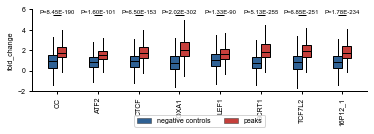

In [11]:
fig,ax = create_boxplot(
    plot_df, "library", "fold_change", "type", ["negative controls", "peaks"], libnames, (-2, 6), 
    figsize=(6,1.5), palette=["#1e61a5", "#dc2924"])

In [12]:
save_file = "../data/figures/peaks_vs_controls.pdf"
save_pdf(save_file, fig)